In [5]:
from pymatgen.io.vasp.inputs import Incar, Kpoints, Poscar, Potcar, VaspInput
from pymatgen.core import Structure, Lattice
from pymatgen.io import vasp
import pymatgen as mg
import numpy as np
from numpy.linalg import inv
import math
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from random import randrange
from itertools import product, combinations
from collections import defaultdict
import shutil
import os
import re
import zipfile
#import torch
def mpdata_duplicates(seq):
    resultstraintally = defaultdict(list)
    for i,item in enumerate(seq):
        resultstraintally[item].append(i)
    return ((locs) for key,locs in resultstraintally.items() 
                            if len(locs)>1)
def delete_1(a):
    delete, delete_f = [], []
    for i in range(len(a)):
        for s in a[i]:
            if s == 1:
                delete.append(i)
    for i in delete:
        if i not in delete_f:
            delete_f.append(i)
    a = np.delete(a, delete_f, axis = 0)
    return a

def supercell_gen_irre(x_axis, y_axis, z_axis):
    x_axis, y_axis, z_axis = x_axis * 2 + 1, y_axis * 2 + 1, z_axis * 2 + 1
    zero_cell = np.zeros(((x_axis, y_axis, z_axis)))
    for i in range(x_axis):
        for j in range(y_axis):
            for k in range(z_axis):
                if i%2 == 1:
                    zero_cell[i][j][k] = abs(j%2 - k%2)
                elif i%2 == 0:
                    zero_cell[i][j][k] = 1 - abs(j%2 - k%2)
    return zero_cell

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        #print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

def getfilename(path):
    zip_list = []
    f_list = os.listdir(path)
    for i in f_list:
        if os.path.splitext(i)[1] == '.zip':
            zip_list.append(i)
            print(i)
    return zip_list
#zero_cell = supercell_gen_irre(3, 4, 4)

def getfoldername(path):
    f_list = os.listdir(path)
    for i in f_list:
        if os.path.splitext(i)[1] == '':
            print(i)
    return

def supercell_gen(cell_num1):
    atom_pos = cell_num1*2 + 1
    zero_cell = np.zeros(((atom_pos, atom_pos, atom_pos)))
    for i in range(atom_pos):
        for j in range(atom_pos):
            for k in range(atom_pos):
                if i%2 == 1:
                    zero_cell[i][j][k] = abs(j%2 - k%2)
                elif i%2 == 0:
                    zero_cell[i][j][k] = 1 - abs(j%2 - k%2)
    return zero_cell

def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()
    return

def gen_crconi(cr_content, co_content, num):
    unit = supercell_gen(num)
    ind_1f, ind_1s = [], []
    #for x in range(100000):
    ind = [i[0] for i in np.ndenumerate(unit) if i[1] == 1]
    tuple_len = [i for i in range(len(ind))]
    train_size = int(len(tuple_len)*cr_content) + randrange(2)
    co_content = co_content/(1-cr_content)
    ind1, ind23 = train_test_split(tuple_len, test_size = len(tuple_len) - train_size, train_size = train_size)
    train_size_sub = int(len(ind23)*co_content) + randrange(2)
    ind2, ind3 = train_test_split(ind23, test_size = len(ind23) - train_size_sub, train_size = train_size_sub)
    
    num = num * 2
    
    cr_position = np.array([ind[i] for i in ind1])/num
    co_position = np.array([ind[i] for i in ind2])/num
    ni_position = np.array([ind[i] for i in ind3])/num
    
    return cr_position, co_position, ni_position, ind

def read(incar_dir):
    with open(incar_dir) as f:
        input_strip = [s.strip() for s in f.readlines()]
    return input_strip

def bash_cp(n, file):
    srcdir = f'/home/wang/runx{n}.sh'
    dstdir = file + f'/runx{n}.sh'

    srcfile = os.path.join(srcdir)
    dstfile = os.path.join(dstdir)
    shutil.copyfile(srcfile, dstfile)

    split_pattern = '[/\\\_]'
    type_dir = re.split(split_pattern, file)
    jobname = 't'+list(type_dir[-1])[-1]+type_dir[-5]

    with open(dstdir, 'w') as rsh:
        if n == 56:
            rsh.write(f'''\
#!bin/sh
#$ -cwd
#$ -V -S /bin/bash
#$ -N {jobname}
#$ -pe smp {n}
#$ -q x64
mpirun -np {n} vasp
    ''')
        else:
            rsh.write(f'''\
#!bin/sh
#$ -cwd
#$ -V -S /bin/bash
#$ -N {jobname}
#$ -pe smp {n}
#$ -q x{n}
mpirun -np {n} vasp
    ''')
        
def write_input(output_dir, param, kpt, n,
               cr_position, co_position, ni_position):
    incar1 = {
        'ISTART' : 0,
        'ICHARG' : 2,
        'ENCUT' : 450,
        'ALGO' : 'Fast',
        'NELM' : 60,
        'EDIFF' : 1e-07,
        'ISMEAR' : 1,
        'SIGMA' : 0.1,
        'PREC' : 'Accurate',
        'POTIM' : 0.2,
        'ISIF' : 2,
        'NSW' : 500,
        'IBRION' : 2,
        'LREAL' : 'Auto',
        'EDIFFG' : 0.001,
        'LPLANE' : '.TRUE.',
        'LSCALU' : '.FALSE.',
        'LWAVE' : '.FALSE.'
    }
    #4:8*8*4
    #3:6*6*3
    incar1 = vasp.Incar(incar1)
    
    specie = [{'Cr0+':1}]*len(cr_position) + [{'Co0+':1}]*len(co_position) + [{'Ni0+':1}]*len(ni_position)
    position1 = np.insert(cr_position, len(cr_position), co_position, axis = 0)
    position = np.insert(position1, len(position1), ni_position, axis = 0)
    position = position.reshape(len(position), 3)
    #print(position)
    #POSCAR
    #lattice_constant = 17.5
    param_a, param_b, param_c = param[0], param[1], param[2]
    lattice = Lattice.from_parameters(a = param_a, b = param_b, c = param_c, 
                                      alpha = 90, beta = 90, gamma = 90)
    #lattice = mg.Lattice(lattice)

    struct = Structure(
        lattice,
        specie,
        position
    )
    sd_flags = np.zeros((len(position), 3))
    for i in range(len(position)):
        if position[i][2] > 0.15 and position[i][2] < 0.3:
            sd_flags[i] += 1
#     print(sd_flags)
    
    poscar = vasp.Poscar(struct, comment = 'SQS SFE CrCoNi')
    poscar.selective_dynamics = sd_flags

    #POTCAR
    potcar = Potcar(symbols = ['Cr_pv_new', 'Co_pv', 'Ni_pv'], functional = 'PBE')
    
    #K-Points
    kpoints = Kpoints(num_kpts=0, style="Gamma", kpts=((kpt[0], kpt[1], kpt[2]), ),
                      kpts_shift=(0, 0, 0))

    vaspinput = VaspInput(incar1, kpoints, poscar, potcar)
    vaspinput.write_input(output_dir)
    bash_cp(n, output_dir)
    return

def write_input_single(output_dir, param, kpt, n,
               cr_position, co_position, ni_position, ele_type):
    incar1 = {
        'ISTART' : 0,
        'ICHARG' : 2,
        'ENCUT' : 350,
        'ALGO' : 'Fast',
        'NELM' : 60,
        'EDIFF' : 1e-05,
        'ISMEAR' : 1,
        'SIGMA' : 0.1,
        'PREC' : 'Normal',
        'POTIM' : 0.2,
        'ISIF' : 2,
        'NSW' : 500,
        'IBRION' : 2,
        'LREAL' : 'Auto',
        'EDIFFG' : 0.001,
        'LPLANE' : '.TRUE.',
        'LSCALU' : '.FALSE.',
        'LWAVE' : '.FALSE.'
    }
    #4:8*8*4
    #3:6*6*3
    incar1 = vasp.Incar(incar1)
    
    position = np.concatenate([cr_position, co_position, ni_position])
    specie = [{ele_type:1}]*len(position)
    #print(position)
    #POSCAR
    #lattice_constant = 17.5
    param_a, param_b, param_c = param[0], param[1], param[2]
    lattice = Lattice.from_parameters(a = param_a, b = param_b, c = param_c, 
                                      alpha = 90, beta = 90, gamma = 90)
    #lattice = mg.Lattice(lattice)

    struct = Structure(
        lattice,
        specie,
        position
    )
    sd_flags = np.zeros((len(position), 3))
    for i in range(len(position)):
        if position[i][2] > 0.15 and position[i][2] < 0.3:
            sd_flags[i] += 1
#     print(sd_flags)
    
    poscar = vasp.Poscar(struct, comment = 'SQS SFE CrCoNi')
    poscar.selective_dynamics = sd_flags

    #POTCAR
    potcar = Potcar(symbols = ['Cr_pv_new', 'Co_pv', 'Ni_pv'], functional = 'PBE')
    
    #K-Points
    kpoints = Kpoints(num_kpts=0, style="Gamma", kpts=((kpt[0], kpt[1], kpt[2]), ),
                      kpts_shift=(0, 0, 0))

    vaspinput = VaspInput(incar1, kpoints, poscar, potcar)
    vaspinput.write_input(output_dir)
    bash_cp(n, output_dir)
    return

In [6]:
path = '/home/wang/Downloads'
zip_list = getfilename(path)
for i in zip_list:
    zip_dir = path + '/' + i
    with zipfile.ZipFile(zip_dir) as existing_zip:
        existing_zip.extractall(path)
        
getfoldername(path)

drive-download-20220516T035424Z-001.zip
.ipynb_checkpoints
try_sqs
Yuyake_recog
Cr30Co60Ni10_SFE_try5
Cr30Co60Ni10_SFE_try4
Cr30Co60Ni10_stack_try1
Cr30Co60Ni10_stack_try4
Cr30Co60Ni10_SFE_try2
Cr30Co60Ni10_SFE_try1
Cr30Co60Ni10_stack_try2
Cr30Co60Ni10_stack_try3
Cr30Co60Ni10_SFE_try3
Cr30Co60Ni10_stack_try5
report
__pycache__


In [7]:
#raw and stack structure input
for i in range(1, 6):
    server_no = 40
    lattice_parameter = 3.495
    file = f'/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_{lattice_parameter}_3_raw_try{i}'

    create_dir(file)
    print(file)

    input_dir = f'/home/wang/Downloads/Cr30Co60Ni10_SFE_try{i}'
    shutil.move(input_dir, file)

    cr_position = np.load(file+f'/Cr30Co60Ni10_SFE_try{i}/Cr30Co60Ni10_SFE_cr_chosen.npy')
    co_position = np.load(file+f'/Cr30Co60Ni10_SFE_try{i}/Cr30Co60Ni10_SFE_co_chosen.npy')
    ni_position = np.load(file+f'/Cr30Co60Ni10_SFE_try{i}/Cr30Co60Ni10_SFE_ni_chosen.npy')

    ratio = lattice_parameter/3.516
    _=write_input(file, [7.458562328*ratio,25.83721781*ratio,24.35956256*ratio], [5,1,1], server_no,
                 cr_position, co_position, ni_position)
#     _=write_input(file, [4.972374885*ratio,28.70801979*ratio,24.35956256*ratio], [5,1,1], server_no,
#                  cr_position, co_position, ni_position)
    
    file_stack = f'/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_{lattice_parameter}_3_stack_try{i}'

    create_dir(file_stack)
    print(file_stack)

    input_dir = f'/home/wang/Downloads/Cr30Co60Ni10_stack_try{i}'
    shutil.move(input_dir, file_stack)

    cr_position_stack = np.load(file_stack+f'/Cr30Co60Ni10_stack_try{i}/Cr30Co60Ni10_stack_cr_stackchosen.npy')
    co_position_stack = np.load(file_stack+f'/Cr30Co60Ni10_stack_try{i}/Cr30Co60Ni10_stack_co_stackchosen.npy')
    ni_position_stack = np.load(file_stack+f'/Cr30Co60Ni10_stack_try{i}/Cr30Co60Ni10_stack_ni_stackchosen.npy')

    _=write_input(file_stack, [7.458562328*ratio,25.83721781*ratio,24.35956256*ratio], [5,1,1], server_no,
                 cr_position_stack, co_position_stack, ni_position_stack)
#     _=write_input(file_stack, [4.972374885*ratio,28.70801979*ratio,24.35956256*ratio], [5,1,1], server_no,
#                  cr_position_stack, co_position_stack, ni_position_stack)

/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_raw_try1
/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_stack_try1
/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_raw_try2
/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_stack_try2
/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_raw_try3
/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_stack_try3
/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_raw_try4
/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_stack_try4
/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_raw_try5
/home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_stack_try5


In [ ]:
for i in {1..5}
do
  cd /home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_raw_try$i
  qsub runx40.sh
  cd /home/wang/SFE/outputs/Cr30Co60Ni10/Cr30Co60Ni10_3.495_3_stack_try$i
  qsub runx40.sh
done

In [ ]:
for i in {1..5}
do
  rm -r /home/wang/SFE/outputs/Cr30Co40Ni30/Cr30Co40Ni30_3.508_3_raw_try$i
  rm -r /home/wang/SFE/outputs/Cr30Co40Ni30/Cr30Co40Ni30_3.508_3_stack_try$i
done

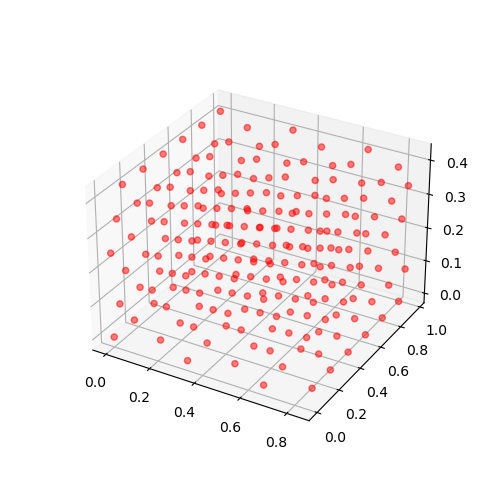

In [52]:
%matplotlib notebook
ind_raw = np.concatenate([cr_position, co_position, ni_position], axis=0)
draw_3d(ind_raw)

In [106]:
i = 6
lattice_parameter = 3.516
files = [f'/home/wang/SFE/outputs/CrCoNi/CrCoNi_{lattice_parameter}_3_raw_try{i}',
        f'/home/wang/SFE/outputs/CrCoNi/CrCoNi_{lattice_parameter}_3_stack_try{i}']
for file in files:
    incar = read(file+'/INCAR')
    if (incar[-1] == 'SIGMA = 0.1'
       and incar[7] == 'ISMEAR = 1'):
        del incar[-1]
        incar[7] = 'ISMEAR = -5'
    #for line in incar:
    f = open(file+'/INCAR', 'w')
    for i in incar:
        f.write(i+'\n')

    f.close()

    contcar = file + '/CONTCAR'
    poscar = file + '/POSCAR'
    shutil.copyfile(contcar, poscar)

In [58]:
#single atom calc
i = 3
server_no = 40
lattice_parameter = 3.516
file = f'/home/wang/SFE/outputs/CrCoNi/CrCoNi_{lattice_parameter}_3_raw_try{i}'
file_stack = f'/home/wang/SFE/outputs/CrCoNi/CrCoNi_{lattice_parameter}_3_stack_try{i}'

cr_position = np.load(file+f'/CrCoNi_SFE_try{i}/CrCoNi_SFE_cr_chosen.npy')
co_position = np.load(file+f'/CrCoNi_SFE_try{i}/CrCoNi_SFE_co_chosen.npy')
ni_position = np.load(file+f'/CrCoNi_SFE_try{i}/CrCoNi_SFE_ni_chosen.npy')
cr_position_stack = np.load(file_stack+f'/CrCoNi_SFE_stack_try{i}/CrCoNi_SFE_stack_cr_stackchosen.npy')
co_position_stack = np.load(file_stack+f'/CrCoNi_SFE_stack_try{i}/CrCoNi_SFE_stack_co_stackchosen.npy')
ni_position_stack = np.load(file_stack+f'/CrCoNi_SFE_stack_try{i}/CrCoNi_SFE_stack_ni_stackchosen.npy')

ele_type = ['Cr0+', 'Co0+', 'Ni0+']
for ele in ele_type:
    _=write_input_single(file+'/' + ele, [4.9724,28.7080,12.1798], [5,1,2], server_no,
                 cr_position, co_position, ni_position, ele)
    _=write_input_single(file_stack+'/' + ele, [4.9724,28.7080,12.1798], [5,1,2], server_no,
                 cr_position_stack, co_position_stack, ni_position_stack, ele)

In [48]:
i = 3
server_no = 40
lattice_parameter = 3.516
file_stack = f'/home/wang/SFE/outputs/CrCoNi/CrCoNi_{lattice_parameter}_3_stack_try{i}'

create_dir(file_stack)
print(file_stack)

input_dir_stack = f'/home/wang/Downloads/CrCoNi_SFE_stack_try3-20220108T053136Z-001.zip'
with zipfile.ZipFile(input_dir_stack) as existing_zip_stack:
    existing_zip_stack.extractall(file_stack)

cr_position_stack = np.load(file_stack+f'/CrCoNi_SFE_stack_try{i}/CrCoNi_SFE_stack_cr_stackchosen.npy')
co_position_stack = np.load(file_stack+f'/CrCoNi_SFE_stack_try{i}/CrCoNi_SFE_stack_co_stackchosen.npy')
ni_position_stack = np.load(file_stack+f'/CrCoNi_SFE_stack_try{i}/CrCoNi_SFE_stack_ni_stackchosen.npy')

_=write_input(file_stack, [4.9724,28.7080,12.1798], [5,1,2], server_no,
             cr_position_stack, co_position_stack, ni_position_stack)

Directory already existed :  /home/wang/SFE/outputs/CrCoNi/CrCoNi_3.516_3_stack_try3
/home/wang/SFE/outputs/CrCoNi/CrCoNi_3.516_3_stack_try3


In [143]:
file = '/home/wang/MSAD/OUTPUTS/Cr40Co30Ni30/Cr40Co30Ni30_3_518_4_try38'
_=write_input(file, 3.518, 4, 0.4, 0.3, 2, 52)

ideal:[102.4, 76.8, 76.8]
Cr, Co, Ni: [103, 77, 76]
variance: 0.35
BBBBB
IIIII
NNNNN
GGGGG
OOOOO!!!!!!


In [168]:
for i in range(28, 33):
    file = f'/home/wang/MSAD/OUTPUTS/Cr40Co15Ni45/Cr40Co15Ni45_3_545_3_try{i}'
    print(file)
    _=write_input(file, 3.545, 3, 0.45, 0.25, 2, 52)

/home/wang/MSAD/OUTPUTS/Cr40Co15Ni45/Cr40Co15Ni45_3_545_3_try28
ideal:[43.2, 16.2, 48.6]
Cr, Co, Ni: [43, 16, 49]
variance: 0.08
BBBBB
IIIII
NNNNN
GGGGG
OOOOO!!!!!!
/home/wang/MSAD/OUTPUTS/Cr40Co15Ni45/Cr40Co15Ni45_3_545_3_try29
ideal:[43.2, 16.2, 48.6]
Cr, Co, Ni: [43, 17, 48]
variance: 0.35
BBBBB
IIIII
NNNNN
GGGGG
OOOOO!!!!!!
/home/wang/MSAD/OUTPUTS/Cr40Co15Ni45/Cr40Co15Ni45_3_545_3_try30
ideal:[43.2, 16.2, 48.6]
Cr, Co, Ni: [43, 17, 48]
variance: 0.35
BBBBB
IIIII
NNNNN
GGGGG
OOOOO!!!!!!
/home/wang/MSAD/OUTPUTS/Cr40Co15Ni45/Cr40Co15Ni45_3_545_3_try31
ideal:[43.2, 16.2, 48.6]
Cr, Co, Ni: [43, 17, 48]
variance: 0.35
BBBBB
IIIII
NNNNN
GGGGG
OOOOO!!!!!!
/home/wang/MSAD/OUTPUTS/Cr40Co15Ni45/Cr40Co15Ni45_3_545_3_try32
ideal:[43.2, 16.2, 48.6]
Cr, Co, Ni: [44, 16, 48]
variance: 0.35
BBBBB
IIIII
NNNNN
GGGGG
OOOOO!!!!!!


In [ ]:
if __name__ == '__main__':
    for i in np.linspace(1, 10, 10):
        dir_in = '/home/Wang/CrCoNi/CrCoNi_{}'.format(int(i))
        write_input(dir_in)

In [39]:
def dup_remov(a):
    sorted_idx = np.lexsort(a.T)
    sorted_a =  a[sorted_idx,:]
    row_mask = np.append([True],np.any(np.diff(sorted_a,axis=0),1))
    out = sorted_a[row_mask]
    return out
    print(len(out))

In [72]:
cr_position, co_position, ni_position, ind = gen_crconi()
cr_position = delete_1(cr_position)
co_position = delete_1(co_position)
ni_position = delete_1(ni_position)
len(ni_position)

169

In [2]:
unit6 = [[[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]],
        [[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0]],
        [[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1,0,1]]]

unit5 = [
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]]
    ]

unit4 = [
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1],[0,1,0,1,0,1,0,1,0],[1,0,1,0,1,0,1,0,1]]
    ]

unit3 = [
    [[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1]],
    [[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0]],
    [[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1],[0,1,0,1,0,1,0],[1,0,1,0,1,0,1]]
]

unit2 = [
    [[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1]],
    [[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0]],
    [[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1]],
    [[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0]],
    [[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1]]
]